# A few tricks

This notebooks contains a few tricks for displaying data with pandas.


[source](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)

In [1]:
import pandas as pd
import numpy as np

# load input
filepath = "data.csv"
df = pd.read_csv(filepath, skiprows=1, sep=";")

Ahora, veamos el contenido de la tabla:

In [2]:
df.style.set_precision(10)

# Resaltar el valor máximo por cada fila

In [61]:
def hl_min_per_row(row, top_k=3):
    """
    Highlight the maximum value for each row
    
    Call this function as follows, using axis=1:
    
        df.style.apply(hl_min_per_row, axis=1)
    
    Input
    row      (n_points, ) pandas Series
    """

    
    # float numbers only
    # this removes 'Problem' and 'm' columns
    to_keep = np.array([isinstance(val, np.float) for val in row ])
    n_labels = (~to_keep).sum()
    n_numbers = to_keep.sum()
    
    # sort numbers and keep the top k
    indices = row[to_keep].values.argsort()[:top_k]
        
    # highlight the top k values
    bg_numbers = [''] * n_numbers
    bg_numbers = ["background-color: #c0c0c0" if i in indices else '' for i in range(n_numbers)]
    
    # highligh the best value
    best = indices[0]
    bg_numbers[best] = "background-color: #808080; color: #ffffff"
    
    bg_labels = [''] * n_labels
    bg_colors = bg_labels + bg_numbers
    
    
    #is_max = s == s.max()
    #return ['background-color: yellow' if v else '' for v in is_max]
    
    return bg_colors

In [62]:
df.style.apply(hl_min_per_row, axis=1)

# Analisis del parametro `divs`

A continuacion revisaremos la influencia del parametro `divs` en `amoead_imss_v16` con `dci_norm_hyp_mean`, un mop a la vez.

In [7]:
# fig_param_divs_sensitivity.py
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os, sys, argparse

# add lab's path to sys.path to import rocket
lab_path = os.path.abspath("../../../")
sys.path.insert(0, lab_path)

# add previous path to import series
exp_path = os.path.abspath("../")
sys.path.insert(0, exp_path)

from rocket.plot.colors import colors, shadows, darks, basecolors
from rocket.plot import load_rcparams, colors, palette, basecolors, plot_series#, plot_shadow_series_mean_sd
from series import get_hv_series, get_igd_series, get_median_last_col_series, get_median_series, get_median_series_nan
from numpy.random import RandomState


def fig_param_divs(mop_names, 
    moea_names=(("moead-pbi-5", "MOEA/D-PBI"),  ("amoead-pbi-5", "AMOEA/D-PBI")),
    list_m_objs=(6, 8, 10), list_iters=(1300, 1600, 2000), list_lower_lims=(None, None, None), 
    list_upper_lims=(None, None, None), step=50, runs=30, save=False, case="", 
    show_plot=True, rotation="horizontal", ylim=(0., 5), plot_title="", suffix="", sq_plot=False):
    """
    Mean+SD of IGD (multiple moeas + aux pops) [shadow plot]
    """
    
    # ajustar tamano titulos
    # labels for mops
    
    load_rcparams((17, 3.4))
    
    if sq_plot:
        load_rcparams((10, 6.2))
    
    rcParams['axes.labelsize']  = 12
    rcParams['axes.titlesize']  = 13.2
    rcParams['legend.fontsize'] = 10

    
    fig  = plt.figure() 
    axes = None
            
    if sq_plot:
        axes = (fig.add_subplot(221), 
            fig.add_subplot(222),
            fig.add_subplot(223),
            fig.add_subplot(224),
            )
    else:
        axes = (fig.add_subplot(141),
            fig.add_subplot(142),
            fig.add_subplot(143),
            fig.add_subplot(144),
            )
            
    letters = ("(a)", "(b)", "(c)", "(d)")
    
    # moeas
    n_moeas = len(moea_names)
    list_moea_labels = [m_label for m_path, m_name, m_label in moea_names]
    
    ax = None
    for i, ax in enumerate(axes):
        
        # params
        m_objs      = list_m_objs[i]
        iters       = list_iters[i]
        
        # setup plot
        ax.cla()
        ax.set_xlim(0.5, n_moeas+0.5)
        ax.set_ylim(ylim[0], ylim[1])
        ax.set_xlabel("$div$")
        ax.set_axis_bgcolor("#f0f0f0")
        
        # setup title
        title = "%s $m = %d$" % (letters[i], m_objs)
        ax.set_title(title)
        
        # setup ylabel
        if i == 0:
            ax.set_ylabel("IGD", labelpad=8)
            
        if i == 2 and sq_plot:
            ax.set_ylabel("IGD", labelpad=8)
        
        # --- mop loop starts ---
        
        for mop_id, (mop_name, mop_label) in enumerate(mop_names):
        
            # data for plot
            data = []
            track = []
            
            # best igd
            best_mean_igd_id = -1
            best_mean_igd_val = np.inf
            
            for moea_id, (experiment_path, moea_name, moea_label) in enumerate(moea_names):
            
                # get serie
                serie = get_igd_series(moea_name, mop_name, m_objs, iters, step, runs, experiment_path)

                # shape (50, ) = (runs, )
                # each value represent the final igd of an independent run
                igd_last_generation = serie[:, -1]
                
                # add to list
                data.append(igd_last_generation.copy())
                
                # add igd mean to track
                mean_igd = np.mean(igd_last_generation)
                track.append(mean_igd)
                
                # update best mean
                if mean_igd < best_mean_igd_val:
                    best_mean_igd_val = mean_igd
                    best_mean_igd_id  = moea_id
                
            
            # make boxplot
            #bp = ax.boxplot(data, patch_artist=True)
            
            # plot track of this mop
            x = np.arange(1, n_moeas+1, 1)
            y = track
            ax.plot(x, y, label=mop_label, c=colors[mop_id])
            
            # plot best point in the track
            x = [best_mean_igd_id + 1]
            y = [best_mean_igd_val]
            ax.plot(x, y, marker="o", c=colors[mop_id], zorder=10)
            
        # --- mop loop ends ---
        
        # setup xticks
        ax.set_xticks([ i for i in range(1, n_moeas+1)])            # 1, 2, ...
        ax.set_xticklabels(list_moea_labels, rotation=rotation)   # 1: "WS", 2: "TE", ...
        
        # remove ticks to avoid confusion with error bars
        ax.xaxis.set_tick_params(length=0)
        ax.yaxis.set_tick_params(length=0)

    # setup main title
    fig.suptitle(plot_title, 
        fontsize=14, 
        horizontalalignment="center")

    
    # setup legend
    if sq_plot:
    
        # setup margins
        plt.subplots_adjust(left=0.1, 
                            right=0.9, 
                            top=0.9, 
                            bottom=0.18, 
                            hspace=0.4)
        # setup legend
        ax.legend(loc='upper center', 
                bbox_to_anchor=(-0.1, -0.3),
                fancybox=False, shadow=False, frameon=False, ncol=5, scatterpoints=1, numpoints=1)
    
    else:
    
        # adjust margins
        plt.subplots_adjust(left=0.06, right=0.94, top=0.85, bottom=0.22)
    
        # setup legend
        ax.legend(loc='upper center', 
                bbox_to_anchor=(-1.31, -0.2),
                fancybox=False, shadow=False, frameon=False, ncol=n_moeas, scatterpoints=1, numpoints=1)
    

    if save:
        for fmt in ("eps", "png"):
            output = "fig_%s_param_divs_%s_%s.%s" % (mop_name, suffix, case, fmt)
            #fig.savefig(output, dpi=300)
            fig.savefig(output, dpi=300, facecolor="#f0f0f0")
            print(output)


    if show_plot:
        plt.show()
        
        
 # input arguments

metric = "igd"
case = "case_a"                                         # label for experiments
runs = 50                                               # number of independent runs
step = 100
save = False                                            # save figure to file    
proposal_path = "../results_%s_hg" % case     

list_m_objs = (3, 5, 8, 10)
list_iters = (300, 500, 800, 1000)


list_lower_lims=((94,-.05), (90,-.05), (84,-.05), (80,-.05)) 
list_upper_lims=((306, 1.1), (510, 1.1), (816, 1.1), (1020,1.1))

    
        
moea_names_norm_true = (
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-5-25-mean-10-ps-normal-ss-gra-norm-true",   "5"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-6-25-mean-10-ps-normal-ss-gra-norm-true",   "6"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-8-25-mean-10-ps-normal-ss-gra-norm-true",   "8"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-10-25-mean-10-ps-normal-ss-gra-norm-true",  "10"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-12-25-mean-10-ps-normal-ss-gra-norm-true",  "12"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-14-25-mean-10-ps-normal-ss-gra-norm-true",  "14"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-16-25-mean-10-ps-normal-ss-gra-norm-true",  "16"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-18-25-mean-10-ps-normal-ss-gra-norm-true",  "18"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-19-25-mean-10-ps-normal-ss-gra-norm-true",  "19"),
            (proposal_path, "amoead_imss_v16-dci_norm_hyp_mean-divs-20-25-mean-10-ps-normal-ss-gra-norm-true",  "20"),
            )

En los siguientes bloques se mostrara el desempeno de MSS en cada problema de prueba.

<IPython.core.display.Javascript object>


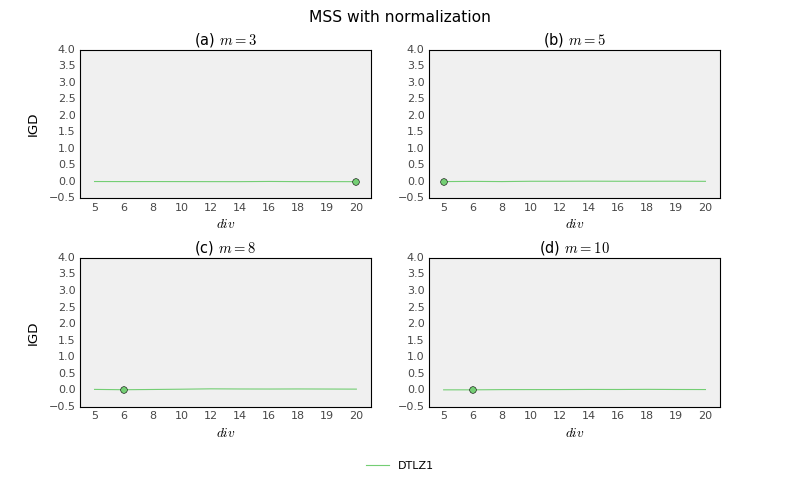

In [8]:
%matplotlib nbagg
mop_names = (
            ("dtlz1", "DTLZ1"),
            )
    
# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);


<IPython.core.display.Javascript object>


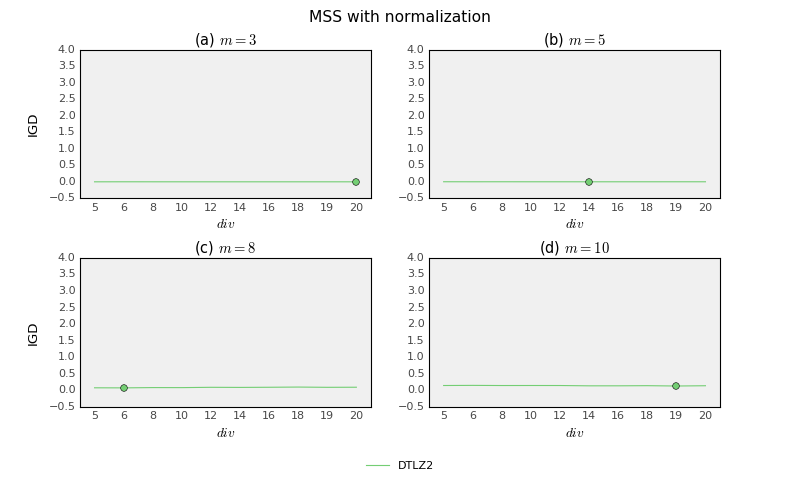

In [9]:
%matplotlib nbagg
mop_names = (
            ("dtlz2", "DTLZ2"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


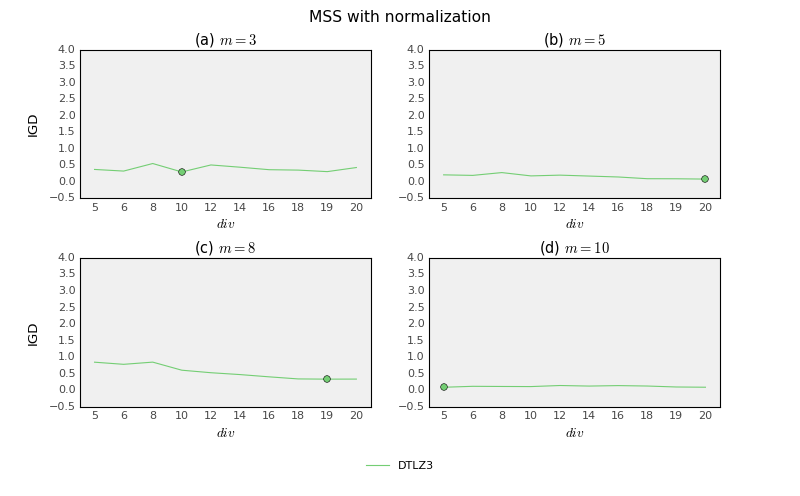

In [18]:
%matplotlib nbagg
mop_names = (
            ("dtlz3", "DTLZ3"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


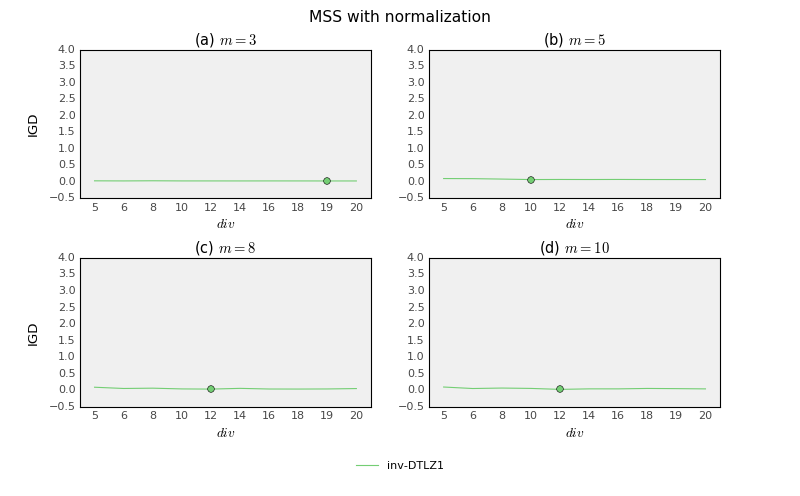

In [19]:
%matplotlib nbagg
mop_names = (
            ("inv-dtlz1", "inv-DTLZ1"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);


<IPython.core.display.Javascript object>


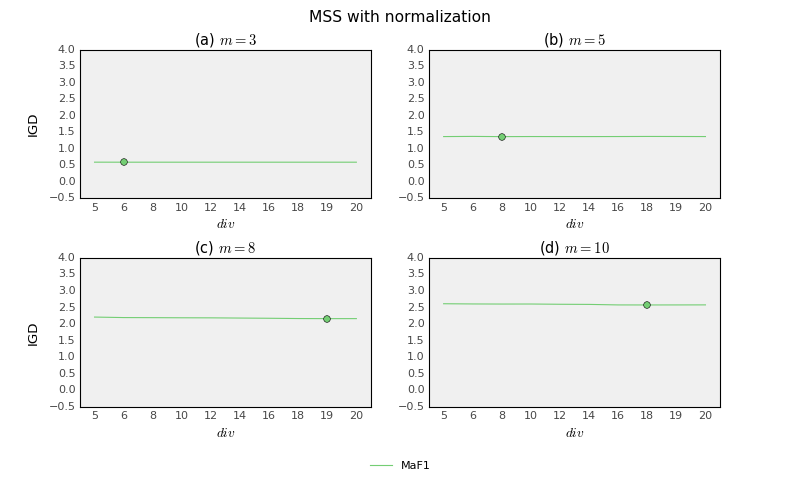

In [20]:
%matplotlib nbagg
mop_names = (
            ("maf1", "MaF1"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);


<IPython.core.display.Javascript object>


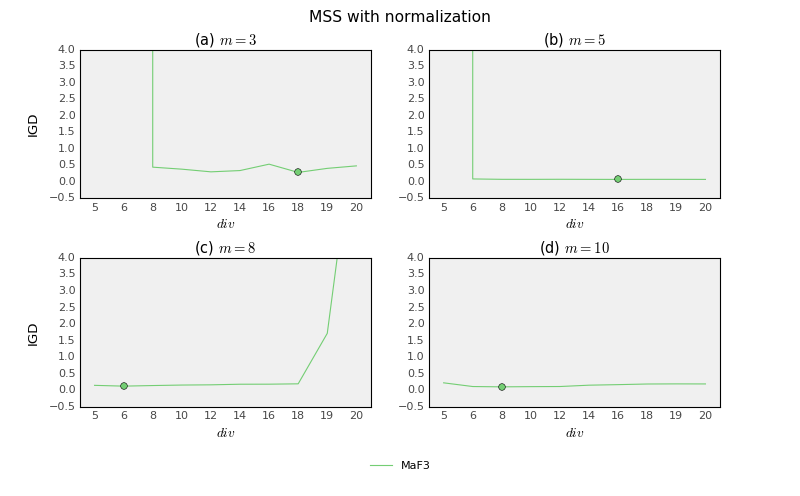

In [21]:
%matplotlib nbagg
mop_names = (
            ("maf3", "MaF3"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);


In [10]:
# m_objs=3,5,8,10, and problem==maf3
rows = (df_case_a_mean["m"].isin((3,5,8,10))) & (df_case_a_mean["Problem"] == "MaF3")
cols = ["Problem", "m"] + csv_mss_norm_true           
sel = df_case_a_mean.loc[rows, cols]

# display table
sel.style.set_precision(10)

In [11]:
sel.style.apply(hl_max)

A partir de la tabla anterior podemos ver que el IGD de `maf3` con `m_objs=5` no aparece en la grafica porque es superior a 50,000.

<IPython.core.display.Javascript object>


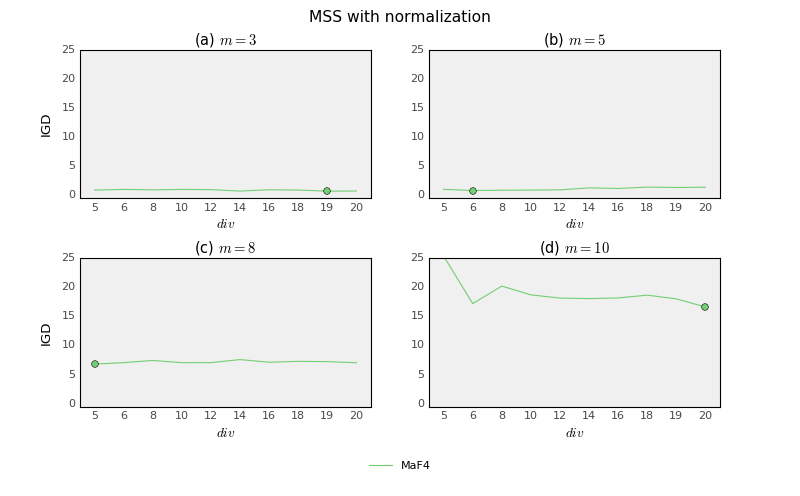

In [23]:
%matplotlib nbagg
mop_names = (
            ("maf4", "MaF4"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 25), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

In [24]:
# m_objs=3,5,8,10, and problem==maf4
rows = (df_case_a_mean["m"].isin((3,5,8,10))) & (df_case_a_mean["Problem"] == "MaF4")
cols = ["Problem", "m"] + csv_mss_norm_true       
sel = df_case_a_mean.loc[rows, cols]

# display table
sel.style.set_precision(10)

La figura y tabla anteriores muestran que el IGD de `maf4` en `m_objs=8, 10` es malo, pero no tan malo como en `maf3`.

<IPython.core.display.Javascript object>


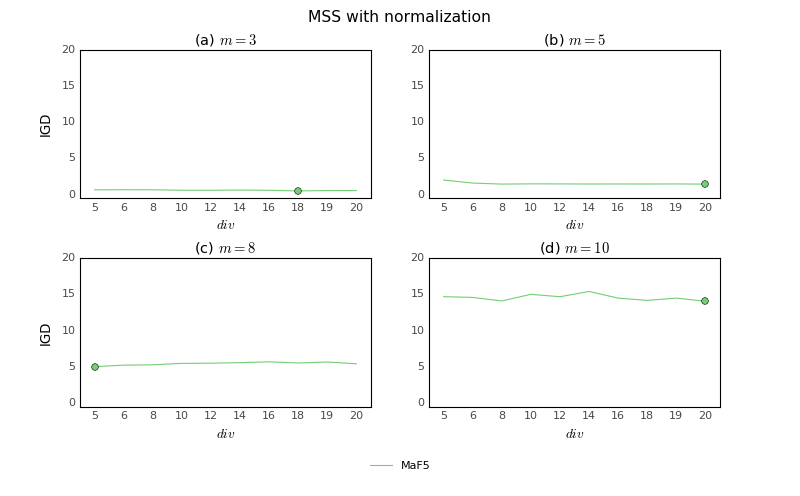

In [20]:
%matplotlib nbagg
mop_names = (
            ("maf5", "MaF5"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 20), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


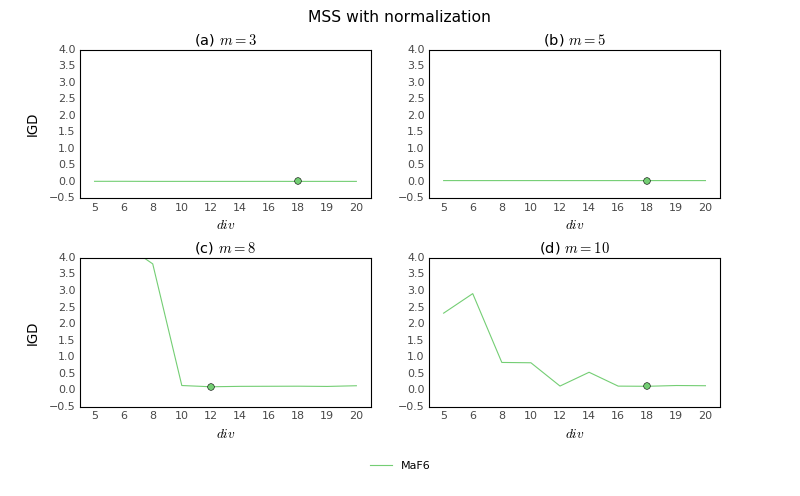

In [21]:
%matplotlib nbagg
mop_names = (
            ("maf6", "MaF6"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


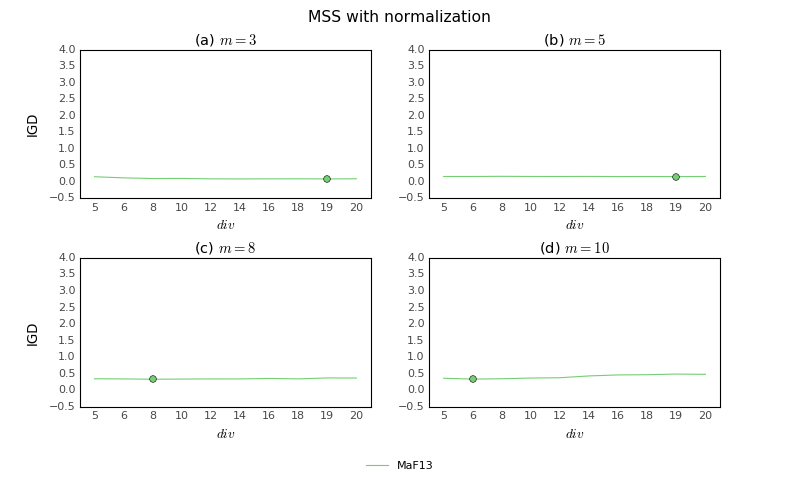

In [22]:
%matplotlib nbagg
mop_names = (
            ("maf13", "MaF13"),
            )

# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization", suffix="norm_true", sq_plot=True);

# Trends

<IPython.core.display.Javascript object>


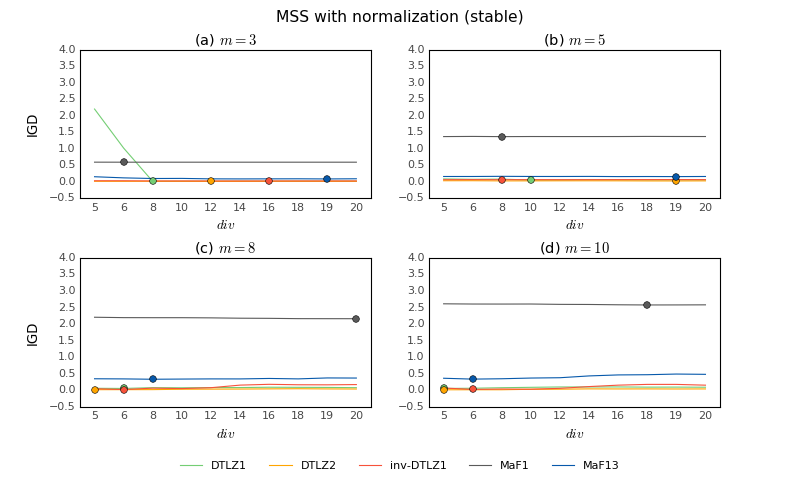

In [23]:
%matplotlib nbagg
mop_names = (
    ("dtlz1", "DTLZ1"),
    ("dtlz2", "DTLZ2"),
    ("inv-dtlz1", "inv-DTLZ1"),
    ("maf1", "MaF1"),
    ("maf13", "MaF13"),
)
    
# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization (stable)", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


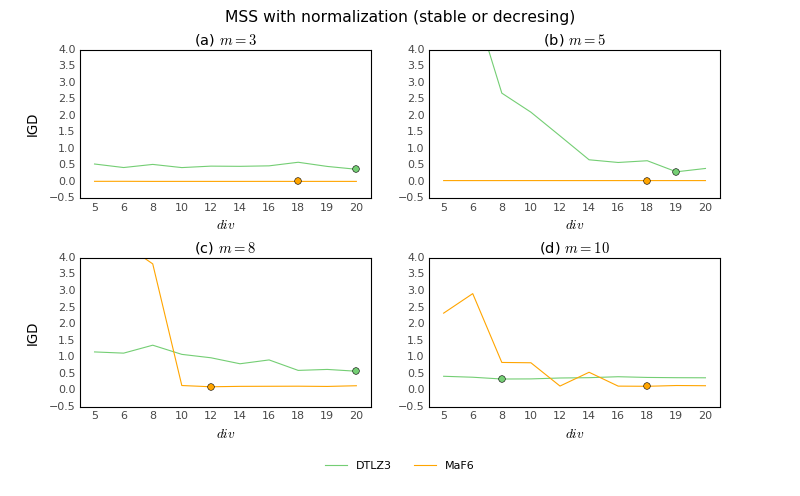

In [24]:
%matplotlib nbagg
mop_names = (
    ("dtlz3", "DTLZ3"),
    ("maf6", "MaF6"),
)
    
# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization (stable or decresing)", suffix="norm_true", sq_plot=True);

<IPython.core.display.Javascript object>


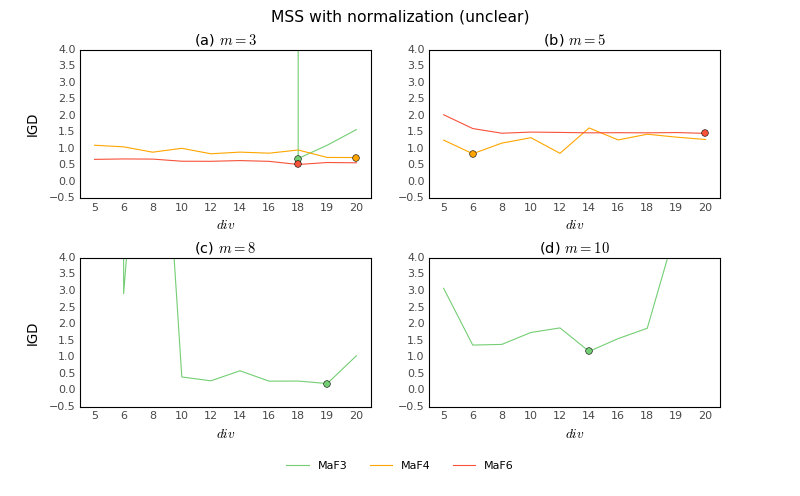

In [25]:
%matplotlib nbagg
mop_names = (
    ("maf3", "MaF3"),
    ("maf4", "MaF4"),
    ("maf5", "MaF6")
)
    
# ---- dont edit from here ----
    
# mss + normalization
fig_param_divs(mop_names, moea_names_norm_true, list_m_objs, 
                list_iters, list_lower_lims, list_upper_lims, 
                step, runs, save, case, ylim=(-0.5, 4), plot_title="MSS with normalization (unclear)", suffix="norm_true", sq_plot=True);